In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image as pil_image
import imageio
import tensorflow
import sklearn.metrics
import itertools
from tensorflow.keras.layers import Input
import tensorflow.keras.applications
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, ReLU, concatenate, MaxPool2D, AvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

c:\Users\zacha\anaconda3\envs\ML_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# num_classes = 100
# input_shape = (32, 32, 3)

# (x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

# print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
# print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
# print(y_train[0:2])
# print(x_train[0, :, :, 0])
# #list_dframe = list(train_df["class"][0:10].astype(int))

# # v = np.reshape(list_dframe, (-1, 1))
# # print(v)

# print(np.mean(x_train))
# print(np.var(x_train))
# print(np.std(x_train))

In [3]:
import skimage.transform

train_df = pd.read_csv('train_data.csv',dtype=str)
val_df = pd.read_csv('val_data.csv',dtype=str)
test_df = pd.read_csv('test_data.csv',dtype=str)

# num_imgs_train = len(train_df['class'])
# x_train = np.zeros((num_imgs_train, 224, 224, 3))

# random_names = np.random.random_integers(num_imgs_train, size=(num_imgs_train,))
# img_names = list(train_df['filename'][random_names])
# y_train = np.expand_dims(np.asarray(train_df['class'][random_names]).astype(int), axis=1)-2

# print(np.min(y_train))

# for i in range(0,num_imgs_train):
#     img = imageio.imread(img_names[i])
#     x_train[i, :, :, :] = skimage.transform.resize(img, (224, 224, 3))

def read_data(data_frame):
    num_imgs_train = len(train_df['class'])
    x_train = np.zeros((num_imgs_train, 224, 224, 3))

    img_names = list(train_df['filename'])
    y_train = np.expand_dims(np.asarray(train_df['class']).astype(int), axis=1)-2


    for i in range(0,num_imgs_train):
        img = imageio.imread(img_names[i])
        x_train[i, :, :, :] = skimage.transform.resize(img, (224, 224, 3))
    return x_train, y_train

x_train, y_train = read_data(train_df)
x_val, y_val = read_data(val_df)
x_test, y_test = read_data(test_df)

# print(np.shape(x_train_2))
# print(np.shape(y_train_2))
# print(y_train_2)

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 224 #72  # We'll resize input images to this size
patch_size = 32 #6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [5]:
num_classes = 5
input_shape = (224, 224, 3)

train_df = pd.read_csv('train_data.csv',dtype=str)
val_df = pd.read_csv('val_data.csv',dtype=str)
test_df = pd.read_csv('test_data.csv',dtype=str)

# train_df["class"] = train_df["class"].astype(str).astype(int)
# val_df["class"] = val_df["class"].astype(str).astype(int)
# test_df["class"] = test_df["class"].astype(str).astype(int)

# train_df["class"] = np.expand_dims(np.asarray(train_df["class"]).astype(int), axis=1)
# val_df["class"] = np.expand_dims(np.asarray(val_df["class"]).astype(int), axis=1)
# test_df["class"] = np.expand_dims(np.asarray(test_df["class"]).astype(int), axis=1)


#train_df_class = np.reshape(list(train_df["class"].astype(int)), (-1, 1))
# val_df_class = np.reshape(val_df["class"], (-1, 1))
# test_df_class = np.reshape(test_df["class"], (-1, 1))

#print(train_df_class[0:10])
#print(np.transpose(np.array(train_df["class"][0:10])))

#Something about casting these labels to floats makes my loss nans?

train_datagen = ImageDataGenerator(fill_mode = "reflect", data_format = "channels_last")
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,\
                                                    directory='',\
                                                    xcol='filename',y_col="class",\
                                                    target_size=(image_size,image_size), color_mode='rgb',\
                                                    batch_size=batch_size, class_mode='raw',\
                                                    shuffle=True) #RETURN TO TRUEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
val_datagen = ImageDataGenerator(fill_mode = "reflect", data_format = "channels_last")
val_generator = val_datagen.flow_from_dataframe(dataframe=val_df,\
                                                directory = '',\
                                                xcol='filename',ycol="class",\
                                                target_size=(image_size,image_size), color_mode='rgb',\
                                                batch_size=batch_size, class_mode='raw',\
                                                shuffle=True)
test_datagen = ImageDataGenerator(fill_mode = "reflect", data_format = "channels_last")
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,\
                                                directory = '',\
                                                xcol='filename',ycol="class",\
                                                target_size=(image_size,image_size), color_mode='rgb',\
                                                batch_size=batch_size, class_mode='raw',\
                                                shuffle=False)

Found 476 validated image filenames.
Found 2346 validated image filenames.
Found 2950 validated image filenames.


In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

# Compute the mean and the variance of the training data for normalization.
#data_augmentation.layers[0].adapt(x_train)

In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [8]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 32 X 32
Patches per image: 49
Elements per patch: 3072


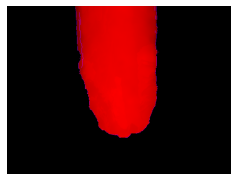

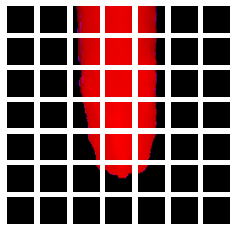

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = imageio.imread(train_df["filename"][0])
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [10]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [11]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [12]:
#def run_experiment(model):

model = create_vit_classifier()


optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

    # checkpoint_filepath = "/tmp/checkpoint"
    # checkpoint_callback = keras.callbacks.ModelCheckpoint(
    #     checkpoint_filepath,
    #     monitor="val_accuracy",
    #     save_best_only=True,
    #     save_weights_only=True,
    # )


    # model.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # return history


#history = run_experiment(vit_classifier)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 224, 224, 3)  7          ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 3072)   0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 49, 64)       199808      ['patches_1[0][0]']          

In [13]:
# step_size_train = np.ceil(train_generator.n/train_generator.batch_size)
# step_size_val = np.ceil(val_generator.n/val_generator.batch_size)

# history = model.fit(
#     train_generator, steps_per_epoch=step_size_train, epochs=2, verbose=1,\
#     validation_data=val_generator, validation_steps=step_size_val,\
#     validation_freq=1#, class_weight=class_weights #class weights break everything and for some reaosn it thinks there are still 10 classes?
#     )

In [14]:
#batch_size = 100
history = model.fit(
        x=x_train,
        y=y_train,
        steps_per_epoch = np.ceil(len(y_train)/batch_size),
        batch_size=batch_size,
        epochs=2,
        validation_data = (x_val, y_val),
        validation_steps = np.ceil(len(y_val)/batch_size),
        validation_freq=1
    )

Epoch 1/2
2/2 [==============================] - 9s 1s/step - loss: 5.6797 - accuracy: 0.3088 - top-5-accuracy: 1.0000 - val_loss: 6.1702 - val_accuracy: 0.2101 - val_top-5-accuracy: 1.0000
Epoch 2/2
2/2 [==============================] - 0s 237ms/step - loss: 7.5159 - accuracy: 0.3004 - top-5-accuracy: 1.0000 - val_loss: 6.5531 - val_accuracy: 0.2626 - val_top-5-accuracy: 1.0000


In [15]:
def normalize_Xtrain(X_train):
    mn = []
    mx = []
    Xn_train = np.zeros(np.shape(X_train))
    X_norm = np.zeros(np.shape(X_train))
    for i in range(len(X_train[0, ::])):
        mn.append(np.min(X_train[::, i]))
        Xn_train[::, i] = X_train[::, i] - mn[i]
    for i in range(len(X_train[0, ::])):
        mx.append(np.max(Xn_train[::, i]))
        if mx[i] == 0:
            X_norm[::, i] = 0
        if mx[i] != 0:
            X_norm[::, i] = Xn_train[::, i]/mx[i]
            
    return X_norm, mx, mn

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
The accuracy of SqueezeNet is:  0.26260504201680673
dict_keys(['loss', 'accuracy', 'top-5-accuracy', 'val_loss', 'val_accuracy', 'val_top-5-accuracy'])
Model precision is:  0.052521008403361345
Model f1_score is:  0.0831946755407654
Model recall is:  0.2
Model MSE is:  1.6365546218487395
Confusion Matrix
[[  0   0   0  16   0]
 [  0   0   0 100   0]
 [  0   0   0 220   0]
 [  0   0   0 125   0]
 [  0   0   0  15   0]]


c:\Users\zacha\anaconda3\envs\ML_env\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


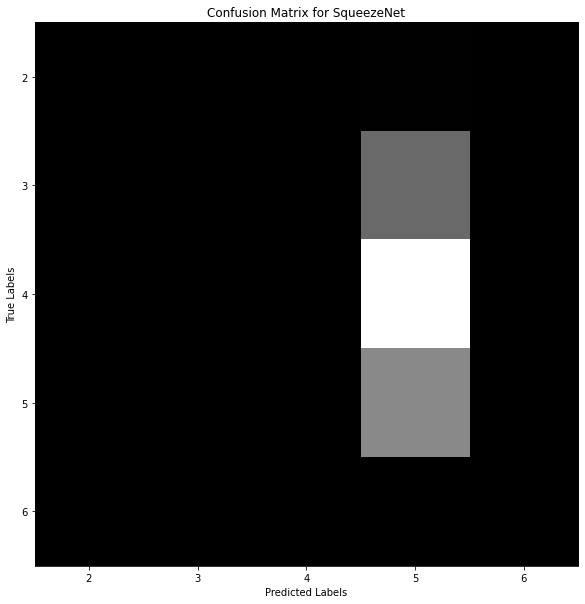

In [16]:
import sklearn.metrics

Y_test_hat=model.predict(x_test)
y_test_hat=Y_test_hat.argmax(axis=-1)

print(y_test_hat[:200])



con_matrix = sklearn.metrics.confusion_matrix(y_test,y_test_hat)
acc=np.diag(con_matrix).sum().astype(float)/con_matrix.sum()
# acc = tensorflow.keras.metrics.Accuracy()
# acc.reset_state()
# acc.update_state(y_test, y_test_hat)


print('The accuracy of SqueezeNet is: ', acc)

min = np.min(con_matrix)
max = np.max(con_matrix)
temp_mat = con_matrix - min
temp_mat = con_matrix/max

plt.figure(figsize=(10,10))
plt.imshow(normalize_Xtrain(temp_mat)[0], cmap='gray')
plt.title('Confusion Matrix for SqueezeNet')
plt.xticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
plt.yticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

print(history.history.keys())
# plt.figure(figsize=(10,10))
# plt.plot(np.arange(0, len(history.history['categorical_accuracy'])), history.history['categorical_accuracy'])
# plt.plot(np.arange(0, len(history.history['val_categorical_accuracy'])), history.history['val_categorical_accuracy'])
# plt.legend(('Training Accuracy', 'Validation Accuracy'))

#Metrics
precision = sklearn.metrics.precision_score(y_test,y_test_hat, average='macro')
print('Model precision is: ', precision)

f1_score = sklearn.metrics.f1_score(y_test,y_test_hat, average='macro')
print('Model f1_score is: ', f1_score)

recall = sklearn.metrics.recall_score(y_test,y_test_hat, average='macro')
print('Model recall is: ', recall)

MSE = sklearn.metrics.mean_squared_error(y_test,y_test_hat)
print('Model MSE is: ', MSE)

print("Confusion Matrix")
print(con_matrix)